## Search for Unknown Profiles: Leiden Clustering
#### Anna Möller anna.moeller@fau.de

_____
### 1. Import libraries:

In [1]:
import matplotlib.pyplot as plt
import json
import os
import cv2
import time
import numpy as np

import pickle
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import umap
import scanpy as sc
import anndata as ad
from initial_analysis import ExpressionAnalyzer
import scipy
from statsmodels.stats.multitest import fdrcorrection

/data/je30bery/.local/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/je30bery/.local/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/je30bery/.local/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning:

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
f = open('/data_slow/je30bery/spatial_proteomics/config.json')
config = json.load(f)

data_path = config["ALS"]
segmentation_results_dir = config["segmentation_results"]
base_path = config["base_path"]

_____
### 2. Get floating-point expression data and normalize:

In [4]:
segment = "cell"
EA = ExpressionAnalyzer(data_path=data_path, segmentation_results_dir_path=segmentation_results_dir, base_path=base_path, membrane_markers=["cd45"], save_plots=False)
EA.run(segment=segment, profile=None)

Calculating expression: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 391.29it/s]


In [5]:
EA.expression_data

CD11b-PE   CD16-PE  CD2-FITC   CD26-PE  CD29-FITC  \
Field of View     Index                                                      
ALS01 - 21297     994    0.000000  0.048387  0.012903  0.000000   0.000000   
                  1846   0.000000  0.047970  0.000000  0.000000   0.173432   
                  132    0.341513  0.000000  0.034765  0.000000   0.235174   
                  8      0.000000  0.484940  0.000000  0.000000   0.042169   
                  2761   0.000000  0.000000  0.017682  0.000000   0.198428   
...                           ...       ...       ...       ...        ...   
Healthy05 - 21334 3536   0.106259  0.090247  0.088792  0.000000   0.007278   
                  3537   0.152709  0.068966  0.136289  0.019704   0.119869   
                  3538   0.112226  0.075730  0.052920  0.000000   0.000912   
                  3539   0.000000  0.000000  0.091688  0.000000   0.002571   
                  3540   0.350305  0.348269  0.103870  0.001018   0.022403   

                           CD3-PE  CD36-FITC   CD38-PE    CD4-PE   CD45-PE  \
Field of View     Index                                                      
ALS01 - 21297     994    0.000000   0.000000  0.525806  0.000000  0.074194   
                  1846   0.000000   0.195572  0.000000  0.000000  0.040590   
                  132    0.012270   0.290389  0.000000  0.000000  0.049080   
                  8      0.000000   0.021084  0.000000  0.000000  0.322289   
                  2761   0.000000   0.212181  0.000000  0.000000  0.017682   
...                           ...        ...       ...       ...       ...   
Healthy05 - 21334 3536   0.106259   0.002911  0.037846  0.209607  0.085881   
                  3537   0.000000   0.001642  0.073892  0.000000  0.001642   
                  3538   0.360401   0.021898  0.019161  0.000000  0.006387   
                  3539   0.000000   0.000000  0.077978  0.052271  0.023136   
                  3540   0.219959   0.015275  0.063136  0.247454  0.050916   

                         ...   CD56-PE  CD57-PE    CD7-PE    CD8-PE  \
Field of View     Index  ...                                          
ALS01 - 21297     994    ...  0.480645      0.1  0.212903  0.000000   
                  1846   ...  0.025830      0.0  0.029520  0.000000   
                  132    ...  0.004090      0.0  0.000000  0.000000   
                  8      ...  0.000000      0.0  0.000000  0.000000   
                  2761   ...  0.023576      0.0  0.161100  0.000000   
...                      ...       ...      ...       ...       ...   
Healthy05 - 21334 3536   ...  0.002911      0.0  0.008734  0.000000   
                  3537   ...  0.044335      0.0  0.000000  0.000000   
                  3538   ...  0.006387      0.0  0.000912  0.481752   
                  3539   ...  0.000857      0.0  0.000000  0.000000   
                  3540   ...  0.026477      0.0  0.010183  0.002037   

                         HLA-DQ-FITC  HLA-DR-PE  NeuN-AF488       PBS  \
Field of View     Index                                                 
ALS01 - 21297     994       0.009677   0.000000    0.041935  0.000000   
                  1846      0.523985   0.180812    0.018450  0.000000   
                  132       0.032720   0.081800    0.057260  0.000000   
                  8         0.018072   0.006024    0.141566  0.000000   
                  2761      0.141454   0.383104    0.080550  0.000000   
...                              ...        ...         ...       ...   
Healthy05 - 21334 3536      0.029112   0.000000    0.000000  0.000000   
                  3537      0.067323   0.000000    0.000000  0.000000   
                  3538      0.020985   0.000000    0.000000  0.000000   
                  3539      0.034276   0.000000    0.000000  0.000000   
                  3540      0.049898   0.001018    0.004073  0.008147   

                            Sample    Group  
Field of View     Index                      
ALS01 - 21297     994        

In [6]:
EA.expression_data = EA.expression_data.sort_index()

y_cols = ["Group", "Sample"]
ys = EA.expression_data[y_cols]
Xs = EA.expression_data.drop(labels=y_cols, axis=1)

Xs_normalized = StandardScaler().fit_transform(Xs)

#df_normalized = pd.DataFrame(data=Xs, index=Xs.index, columns=Xs.columns)

#binary_df = (df_normalized > 0)
#binary_df = binary_df.astype(int)
#binary_df.to_pickle(f"./binary_expression_{segment}_1.pkl")  

_____
### 2. Configure scanpy and create anndata object for Leiden clustering:

In [7]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==1.4.2 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.5 pynndescent==0.5.10


In [8]:
expression_data = EA.expression_data
sample_names = expression_data.index.get_level_values('Field of View')
cell_counts = expression_data.index.get_level_values('Index')

# Convert the DataFrame to AnnData
adata = ad.AnnData(expression_data.drop(columns=['Sample', 'Group']).values)

# Set the sample names and cell counts as observations and variables in the AnnData object
adata.obs['sample_name'] = sample_names
adata.obs['cell_count'] = cell_counts
adata.obs['sample'] = expression_data["Sample"].values
adata.obs['group'] = expression_data["Group"].values


# Optionally, you may want to transpose the data if the antigens are in columns and cells are in rows
#adata = adata.transpose()

# Perform any necessary preprocessing steps
# For example, you can normalize the data using scanpy's pp.normalize_total function
sc.pp.normalize_total(adata)

sc.pp.neighbors(adata)

# Perform Leiden clustering
sc.tl.leiden(adata)

# Access the cluster labels
cluster_labels = adata.obs['leiden']
sc.tl.umap(adata)

normalizing counts per cell
    finished (0:00:00)
computing neighbors
    using data matrix X directly


_normalization.py (197): Some cells have zero counts


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
running Leiden clustering


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


    finished: found 27 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:05:18)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:20)


In [9]:
adata.obs['sample'] = expression_data["Sample"].values
adata.obs['group'] = expression_data["Group"].values

_____
### 3. Show confusion matrix/ distribution over leiden labels and samples:

Text(0.5, 20.777777777777786, 'Leiden cluster')

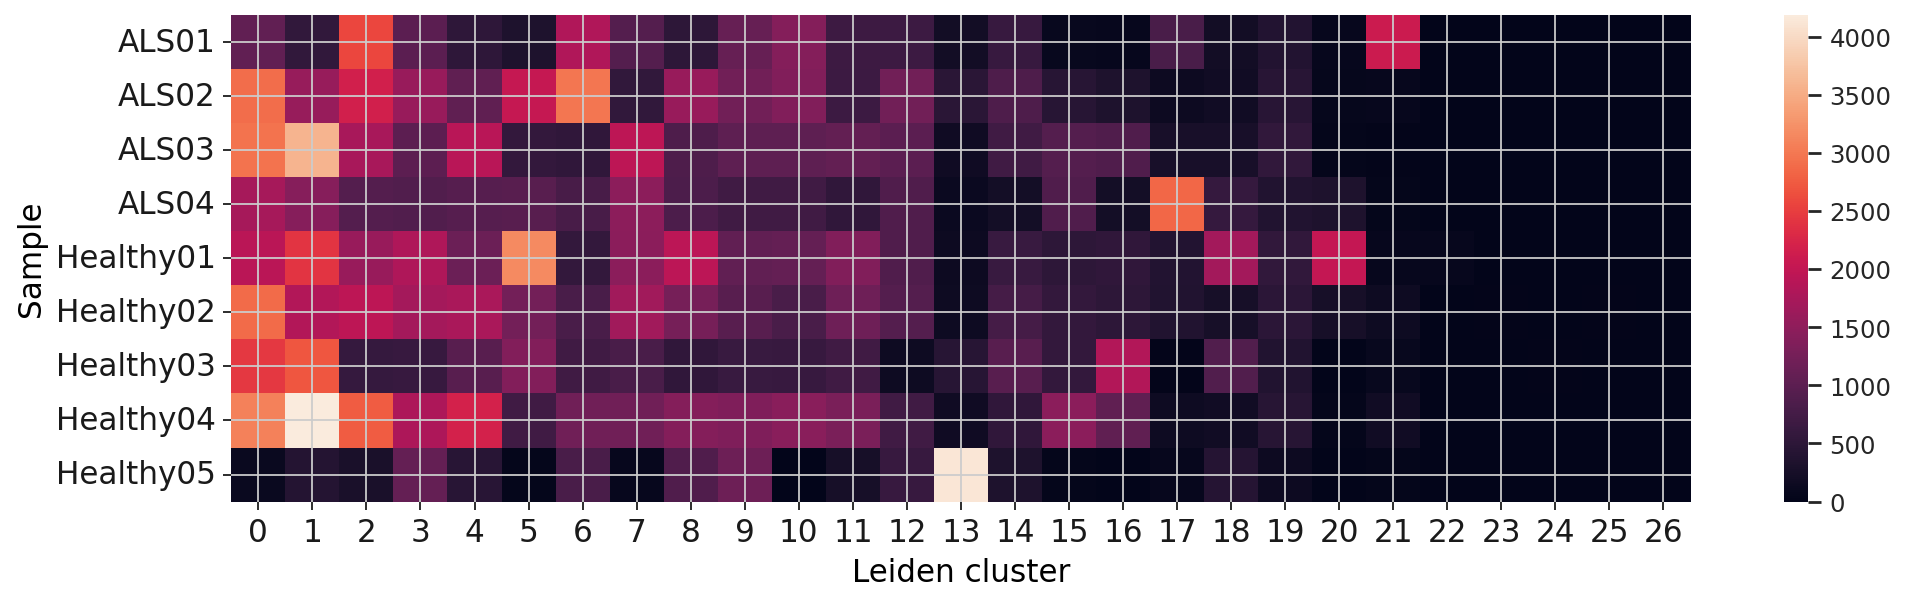

In [10]:
leiden = adata.obs["leiden"].values.to_numpy().astype(int)
sample = adata.obs["sample"].values.astype(str)
df = pd.DataFrame({"leiden": leiden, "sample": sample, "group":adata.obs['group'].values.astype(str)})

leiden_labels = np.unique(leiden)
samples = np.unique(sample)

conf = np.zeros((len(leiden_labels), len(samples)))
for i, l in enumerate(leiden_labels):
    for j, s in enumerate(samples):             
        conf[i,j] = len(np.where(sample[np.where(leiden == l)] == s)[0])
        
df = pd.DataFrame(conf.T, columns=leiden_labels, index=samples)

plt.subplots(figsize=(15,4))
sns.set_theme(style="white")
sns.heatmap(df,square=True)
plt.ylabel("Sample")
plt.xlabel("Leiden cluster")
#plt.savefig("leiden_cells_heatmap_samples.png")

Text(0.5, 113.86666666666669, 'Leiden cluster')

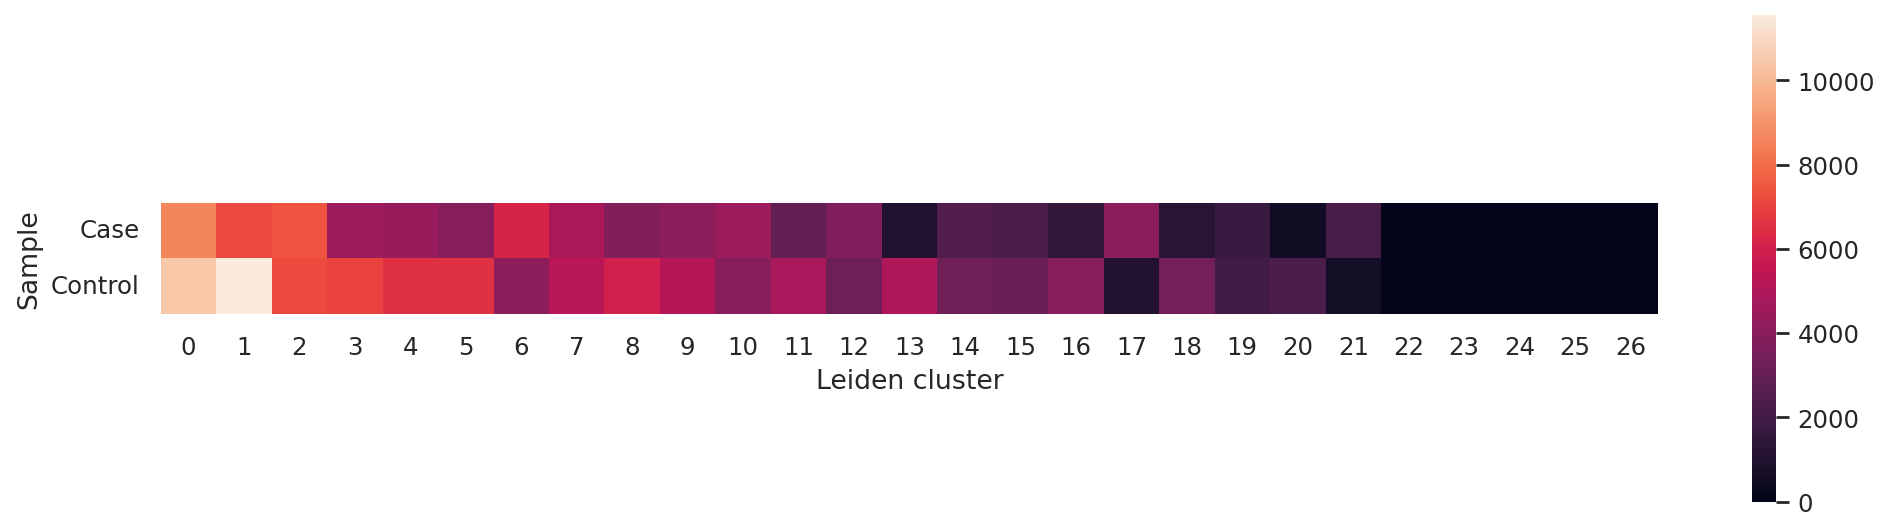

In [11]:
leiden = adata.obs["leiden"].values.to_numpy().astype(int)
group = adata.obs['group'].values.astype(str)

leiden_labels = np.unique(leiden)
groups = np.unique(group)

conf = np.zeros((len(leiden_labels), len(groups)))
for i, l in enumerate(leiden_labels):
    for j, s in enumerate(groups):             
        conf[i,j] = len(np.where(group[np.where(leiden == l)] == s)[0])
        
df = pd.DataFrame(conf.T, columns=leiden_labels, index=groups)

plt.subplots(figsize=(15,4))
sns.set_theme(style="white")
sns.heatmap(df,square=True)
plt.ylabel("Sample")
plt.xlabel("Leiden cluster")
#plt.savefig("leiden_cells_heatmap_groups.png")